C:\Users\Marianne\Anaconda3\lib\site-packages\matplotlib\figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


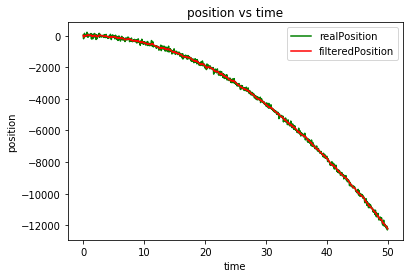

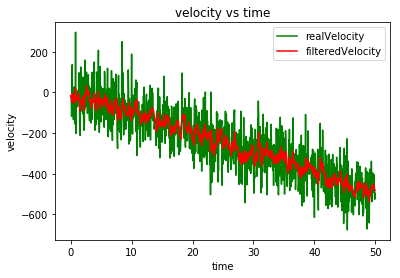

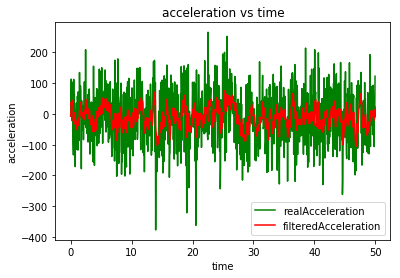

In [20]:
import numpy
import matplotlib.pyplot as plt
import random

# DESCRIPTION:
# This is a self contained demonstration of the Kalman Filter code to present to Dr. Peterson and the class
# Dummy data is created and distorted with noise
# The Kalman Filter is fed only the dummy data that is distorted with noise and is tasked to filter out noise

# TODO:
# - [ ] Get this to handle 3 dimensions
#       - Can currently only handle 1 dimension

# NOTE:
# The success of this Kalman Filter depends heavily on how well we model the system and take into account covariances
# The validity of this demonstration doesn't guarantee us a good Kalman Filter for American Sign Language
# ASL Kalman Filter is modelled slightly differently than this demonstration

initialPosition = 0
initialVelocity = 5
MatrixSize      = 1000
whiteNoiseSTDev = 90
deltaT          = 0.05

stateTransition = numpy.array(([1,deltaT,0.5*deltaT**2],[0,1,deltaT],[0,0,1]))

def main():
    
    # Create dummy data
    measuredStates = dataGenerator(initialPosition, initialVelocity, deltaT, MatrixSize, whiteNoiseSTDev, stateTransition)
    
    # Create noise
    whiteNoise = whiteNoiseGenerator(whiteNoiseSTDev, MatrixSize)
    
    # Create sample data
    randPosition = random.randint(0,10)
    randVelocity = random.randint(0,10)
    randProcess  = dataGenerator(randPosition, randVelocity, deltaT, MatrixSize, whiteNoiseSTDev, stateTransition)

    staticPositionData     = dataProcessor(0, whiteNoise)
    staticVelocityData     = dataProcessor(1, whiteNoise)
    staticAccelerationData = dataProcessor(2, whiteNoise)

    movingPositionData     = dataProcessor(0, randProcess)
    movingVelocityData     = dataProcessor(1, randProcess)
    movingAccelerationData = dataProcessor(2, randProcess)

    DEMO = Physics_Filter()

    # Determine initial conditions
    DEMO.setupKalmanFilterDEMO(staticPositionData, staticVelocityData, staticAccelerationData, movingPositionData, movingVelocityData, movingAccelerationData)
    DEMO.priorState = measuredStates[0]

    filteredData = numpy.zeros((MatrixSize,3))

    state = 0

    while (state < (MatrixSize)):
        # Implement Kalman Filter
        filteredData[state] = DEMO.KalmanFilterxvaDEMO(measuredStates[state], deltaT, stateTransition)
        state = state+1

    # Theoretical data
    cleanData = canonSimulator(initialPosition, initialVelocity, deltaT, MatrixSize, stateTransition)
    
    # "Real world" data
    realData  = measuredStates
    
    # Process lots of data
    realPosition     = dataProcessor(0, realData)
    realVelocity     = dataProcessor(1, realData)
    realAcceleration = dataProcessor(2, realData)
    
    filteredPosition     = dataProcessor(0, filteredData)
    filteredVelocity     = dataProcessor(1, filteredData)
    filteredAcceleration = dataProcessor(2, filteredData)
    
    cleanPosition     = dataProcessor(0, cleanData)
    cleanVelocity     = dataProcessor(1, cleanData)
    cleanAcceleration = dataProcessor(2, cleanData)

    T = numpy.arange(0, MatrixSize*deltaT, deltaT)
    
    # Graph everything 
    plt.figure(1)
    plt.plot(T, realPosition, 'g', label="realPosition")
    plt.plot(T, filteredPosition,'r', label="filteredPosition")
    #plt.plot(T, cleanPosition,'b', label="cleanPosition")
    plt.legend(loc='best')
    plt.title("position vs time")
    plt.ylabel("position")
    plt.xlabel("time")
    
    plt.figure(2)
    plt.plot(T, realVelocity, 'g', label="realVelocity")
    plt.plot(T, filteredVelocity,'r', label="filteredVelocity")
    #plt.plot(T, cleanVelocity, 'b', label="cleanVelocity")
    plt.legend(loc='best')
    plt.title("velocity vs time")
    plt.ylabel("velocity")
    plt.xlabel("time")
    
    plt.figure(3)
    plt.plot(T, realAcceleration, 'g', label="realAcceleration")
    plt.plot(T, filteredAcceleration, 'r',label="filteredAcceleration")
    #plt.plot(T, cleanAcceleration, 'b', label="cleanAcceleration")
    plt.legend(loc='best')
    plt.title("acceleration vs time")
    plt.ylabel("acceleration")
    plt.xlabel("time")
    
    plt.figure(1).show()
    plt.figure(2).show()
    plt.figure(3).show()

def dataProcessor(spot, array):
    
    data = [x[spot] for x in array]
    
    return data
                    
def whiteNoiseGenerator(std, matrixSize):
    
    return numpy.random.normal( 0, std, size=(matrixSize,3) )
    
def canonSimulator(initialPos, initialVel, deltaT, matrixSize, stateTransition):
    
    measuredState       = numpy.zeros((matrixSize,3))
    initialAcceleration = -9.98
    initialState        = [initialPos, initialVel, initialAcceleration]
    measuredState[0]    = initialState
    
    index = 0
    
    while (index < (matrixSize-1)): 
        measuredState[index+1] = numpy.dot(stateTransition,measuredState[index])
        index                  = index+1
        
    return measuredState

def dataGenerator(initialPos, initialVel, deltaT, matrixSize, whiteNoiseSTD, stateTransition):
    
    whiteNoise           = whiteNoiseGenerator(whiteNoiseSTD, matrixSize)
    canonSimulation      = canonSimulator(initialPos, initialVel, deltaT, matrixSize, stateTransition)
    noisyCanonSimulation = canonSimulation + whiteNoise
    
    return noisyCanonSimulation

class Physics_Filter(object):
    
    def __init__(self):
        self.processNoise         = 0
        self.measurementNoise     = 0
        self.initialStateMatrix   = 0
        self.priorStateMatrix     = 0
        self.predictedStateMatrix = 0
        self.deltaT               = 0
        self.priorState           = 0
        self.predictedState       = 0
        self.KalmanGain           = 0
    
    def setupKalmanFilterDEMO(self,staticPositionData, staticVelocityData, staticAccelerationData, movingPositionData, movingVelocityData, movingAccelerationData):
        
        self.measurementNoise   = self.getCovarxva(staticPositionData, staticVelocityData, staticAccelerationData)
        self.initialStateMatrix = self.getCovarxva(movingPositionData, movingVelocityData, movingAccelerationData)
        self.priorStateMatrix   = self.initialStateMatrix
        
        randomPosition     = numpy.random.randint(min(staticPositionData), max(staticPositionData), size=(len(staticPositionData),3))
        randomVelocity     = numpy.random.randint(min(staticVelocityData), max(staticVelocityData), size=(len(staticVelocityData),3))
        randomAcceleration = numpy.random.randint(min(staticAccelerationData), max(staticAccelerationData), size=(len(staticAccelerationData),3))
        
        self.processNoise = 0.05*self.measurementNoise
    
    def KalmanFilterxvaDEMO(self, measuredState, deltaT, stateTransition):
        
        self.deltaT    = deltaT
        self.predictxvaDEMO(stateTransition)
        predictedState = self.predictedState
        priorState     = self.update(measuredState)
        
        return priorState
    
    def predictxvaDEMO(self, stateTransition):
                
        self.stateTransition      = stateTransition
        self.predictedState       = numpy.dot(self.stateTransition,self.priorState)
        self.predictedStateMatrix = numpy.dot(numpy.dot(self.stateTransition,self.priorStateMatrix),self.stateTransition.T) + self.processNoise

    def update(self, measuredState):

        scalingFactor         = self.predictedStateMatrix + self.measurementNoise

        self.KalmanGain       = numpy.dot(self.predictedStateMatrix,numpy.linalg.inv(scalingFactor))
        self.priorState       = self.predictedState + numpy.dot(self.KalmanGain,numpy.subtract(measuredState,self.predictedState))
        self.priorStateMatrix = numpy.subtract(self.predictedStateMatrix,numpy.dot(self.KalmanGain,self.predictedStateMatrix))
        
        return self.priorState


    def getCovarxva(self, positionData, velocityData, accelerationData):
        
        positionVar      = numpy.var(positionData)
        velocityVar      = numpy.var(velocityData)
        accelerationVar  = numpy.var(accelerationData)
        
        covarMatrix      = numpy.zeros((3,3))
        covarMatrix[0,0] = positionVar
        covarMatrix[1,1] = velocityVar
        covarMatrix[2,2] = accelerationVar
        
        return covarMatrix

if __name__ == "__main__":
    main()
